In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random

In [3]:
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
image_size = 224
batch_size = 32
freeze_num = 5
num_classes = 5
save_model_filename = 'cassava_transfer.h5'

In [5]:
train = pd.read_csv('./cassava-leaf-disease-classification/train.csv')

In [6]:
train.head(10)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
5,1000837476.jpg,3
6,1000910826.jpg,2
7,1001320321.jpg,0
8,1001723730.jpg,4
9,1001742395.jpg,3


In [7]:
data = {"0":"Cassava Bacterial Blight (CBB)",
        "1":"Cassava Brown Streak Disease (CBSD)",
        "2":"Cassava Green Mottle (CGM)",
        "3":"Cassava Mosaic Disease (CMD)",
        "4":"Healthy"}

disease_label = pd.DataFrame(data=data.values(),index=data.keys(),columns=['Disease_Name'])

In [8]:
disease_label

,Disease_Name
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [9]:
train_path = './cassava-leaf-disease-classification/train_images'
test_path = './cassava-leaf-disease-classification/test_images'

In [10]:
def image_path(image):
    return os.path.join(train_path,image)

train['image_id'] = train['image_id'].apply(image_path)

In [11]:
train.head(10)

,image_id,label
0,./cassava-leaf-disease-classification/train_im...,0
1,./cassava-leaf-disease-classification/train_im...,3
2,./cassava-leaf-disease-classification/train_im...,1
3,./cassava-leaf-disease-classification/train_im...,1
4,./cassava-leaf-disease-classification/train_im...,3
5,./cassava-leaf-disease-classification/train_im...,3
6,./cassava-leaf-disease-classification/train_im...,2
7,./cassava-leaf-disease-classification/train_im...,0
8,./cassava-leaf-disease-classification/train_im...,4
9,./cassava-leaf-disease-classification/train_im...,3


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [13]:
train['label'] = train['label'].astype('str')

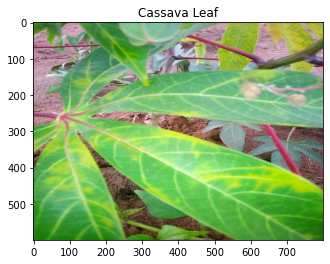

In [14]:
# display random image

index = np.random.randint(0,len(train))

plt.imshow(imread(train['image_id'][index]))
plt.title('Cassava Leaf')

plt.show()

C:\Users\pomat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


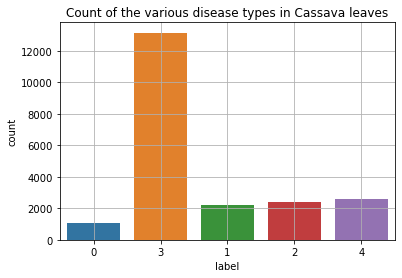

In [15]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of the various disease types in Cassava leaves')
plt.grid()
plt.show()

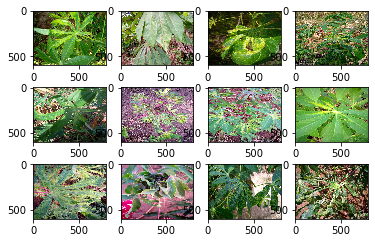

In [16]:
n_rows = 3
n_cols = 4

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        
        leaf_img = np.random.randint(0, len(train))
        img = imread(train.iloc[leaf_img]['image_id'])
        
        plt.imshow(img, cmap='binary',interpolation='nearest')

In [17]:
image_generator = ImageDataGenerator(rotation_range=15, horizontal_flip=True, vertical_flip=True,
                                     shear_range=0.2, zoom_range=0.2, brightness_range=[0.1,0.3], fill_mode='nearest', 
                                     validation_split=0.2, rescale = 1./255,
                                     preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [18]:
train_generator = image_generator.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                      subset='training', color_mode='rgb', batch_size=batch_size, seed=42,
                                                      shuffle=True, class_mode='categorical', target_size=(image_size,image_size))

Found 17118 validated image filenames belonging to 5 classes.


In [19]:
validation_generator = image_generator.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                   subset='validation', color_mode='rgb', batch_size=batch_size, seed=42,
                                                   shuffle=False, class_mode='categorical', target_size=(image_size,image_size))

Found 4279 validated image filenames belonging to 5 classes.


In [20]:
%load_ext tensorboard

import datetime

In [21]:
model = keras.models.load_model('vgg.h5')

Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/re

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localh

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalN

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localho

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device 

In [22]:
len(model.layers)

25

In [23]:
# freeze first {freeze_num} layers

for i in range(freeze_num):
    model.layers[i].trainable = False

In [24]:
# make the next layers trainable except the last layer

for i in range(freeze_num, len(model.layers)-1):
    model.layers[i].trainable = True

In [25]:
# add one new layer

layer = model.layers[len(model.layers)-1].output
layer = Dense(num_classes, activation='softmax')(layer)

model = Model(inputs=model.input, outputs=layer)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

In [32]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy']
)

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhos

In [33]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)      

In [34]:
log_dir = "logs/cassava_transfer/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [35]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint(save_model_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False)

In [36]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [37]:
epoch = 100

history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[tensorboard_callback, early_stopping, model_checkpoint, reduce_lr]
)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteGraphSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSumm

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device 

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:loc

 73/535 [===>..........................] - ETA: 2:57 - loss: 1.3149 - accuracy: 0.5458Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


117/535 [=====>........................] - ETA: 2:41 - loss: 1.2687 - accuracy: 0.5761Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


161/535 [========>.....................] - ETA: 2:25 - loss: 1.2507 - accuracy: 0.5885Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


205/535 [==========>...................] - ETA: 2:08 - loss: 1.2412 - accuracy: 0.5950Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


249/535 [============>.................] - ETA: 1:51 - loss: 1.2291 - accuracy: 0.6008Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


293/535 [===============>..............] - ETA: 1:34 - loss: 1.2232 - accuracy: 0.6032Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


337/535 [=================>............] - ETA: 1:17 - loss: 1.2270 - accuracy: 0.6016Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


381/535 [====================>.........] - ETA: 1:00 - loss: 1.2212 - accuracy: 0.6041Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


425/535 [======================>.......] - ETA: 43s - loss: 1.2182 - accuracy: 0.6052Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


469/535 [=========================>....] - ETA: 25s - loss: 1.2224 - accuracy: 0.6025Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


513/535 [===========================>..] - ETA: 8s - loss: 1.2171 - accuracy: 0.6053Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.2169 - accuracy: 0.6051Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Opt

Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_6690 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

 75/535 [===>..........................] - ETA: 3:00 - loss: 1.2093 - accuracy: 0.6033Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


119/535 [=====>........................] - ETA: 2:44 - loss: 1.2007 - accuracy: 0.6087Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


163/535 [========>.....................] - ETA: 2:26 - loss: 1.1896 - accuracy: 0.6148Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


207/535 [==========>...................] - ETA: 2:09 - loss: 1.1913 - accuracy: 0.6134Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


251/535 [=============>................] - ETA: 1:52 - loss: 1.1937 - accuracy: 0.6119Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


295/535 [===============>..............] - ETA: 1:35 - loss: 1.1907 - accuracy: 0.6133Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


339/535 [==================>...........] - ETA: 1:17 - loss: 1.1898 - accuracy: 0.6136Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


383/535 [====================>.........] - ETA: 1:00 - loss: 1.1878 - accuracy: 0.6145Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


427/535 [======================>.......] - ETA: 42s - loss: 1.1889 - accuracy: 0.6137Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


471/535 [=========================>....] - ETA: 25s - loss: 1.1911 - accuracy: 0.6129Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


515/535 [===========================>..] - ETA: 7s - loss: 1.1883 - accuracy: 0.6143Executing op __inference_train_function_5325 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.1877 - accuracy: 0.6146Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

KeyboardInterrupt: 

In [ ]:
%tensorboard --logdir logs/cassava_transfer

In [ ]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

results = pd.DataFrame(history.history)

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(results[['loss', 'val_loss']])
axs[0].set_title('Model Loss')

axs[1].plot(results[['acc', 'val_acc']])
axs[1].set_title('Model Accuracy')

plt.show()

In [ ]:
test = pd.read_csv('./cassava-leaf-disease-classification/sample_submission.csv')

test_path = './cassava-leaf-disease-classification/test_images'
def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)

test['label'] = test['label'].astype('str')

test.head()

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=applications.vgg16.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

In [ ]:
output = model.predict_generator(test_generator)

In [ ]:
print(np.argmax(output))